In [1]:
import argparse, pydicom
import torch
import numpy as np

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

/home/ypark6/.uvenv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    return cfg

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

def load_case_paths_ebrt(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("*.dcm"), "CT series"),
    }

In [3]:
cfg = load_hyperparams(Path("config.yaml"))
cfg

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}}

In [4]:
data_root = Path(cfg['run']['data-root'])

for idx_case in range(6, 26):
    case_id = Path(f"Case{idx_case}")
    print(f"Data root: {data_root}")
    print(f"Case ID: {case_id}")
    try: paths = load_case_paths(data_root, case_id)
    except: continue

    ## CT
    print(paths['ct'])
    try: ct_image, ct_array, _ = dhelp.load_ct_volume(paths['ct'])
    except: continue

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case7
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case7/CT_0_20240123/series_2_1.3.6.1.4.1.2452.6.119199712.1243047606.2501252749.3382324425
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case8
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case8/CT_0_20240202/series_2_1.3.6.1.4.1.2452.6.3351915917.1076593743.1821453241.828281496
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case9
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case9/CT_0_20240318/series_2_1.3.6.1.4.1.2452.6.943708742.1313552506.3846646192.867230644
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case10
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case10/CT_0_20240823/series_4_1.3.6.1.4.1.2452.6.356448218.1341785047.3605713818.1153220155
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case11
/mnt/d/PRV/GYN_Geneva_w

In [5]:
cfg['run']['data-root'] = Path("/mnt/d/PRV/GYN External Beam CT Datasets")
cfg['run']['case'] = Path("Case1")

data_root = Path(cfg['run']['data-root'])

for idx_case in range(1, 11):
    case_id = Path(f"Case{idx_case}")
    print(f"Data root: {data_root}")
    print(f"Case ID: {case_id}")
    paths = load_case_paths_ebrt(data_root, case_id)

    ## CT
    path_ct = data_root / case_id
    print(path_ct)
    ct_image, ct_array, _ = dhelp.load_ct_volume(path_ct)

Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case1
/mnt/d/PRV/GYN External Beam CT Datasets/Case1
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case2
/mnt/d/PRV/GYN External Beam CT Datasets/Case2
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case3
/mnt/d/PRV/GYN External Beam CT Datasets/Case3
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case4
/mnt/d/PRV/GYN External Beam CT Datasets/Case4
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case5
/mnt/d/PRV/GYN External Beam CT Datasets/Case5
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case6
/mnt/d/PRV/GYN External Beam CT Datasets/Case6
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case7
/mnt/d/PRV/GYN External Beam CT Datasets/Case7
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case8
/mnt/d/PRV/GYN External Beam CT Datasets/Case8
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case9
/mnt/d/PRV/GYN Extern

In [6]:
bt_image, bt_array, _ = dhelp.load_ct_volume(Path("/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617"))
ebrt_image, ebrt_array, _ = dhelp.load_ct_volume(Path("/mnt/d/PRV/GYN External Beam CT Datasets/Case1"))

In [7]:
ct_array.shape

(246, 512, 512)

(160, 512, 512) (268, 512, 512)


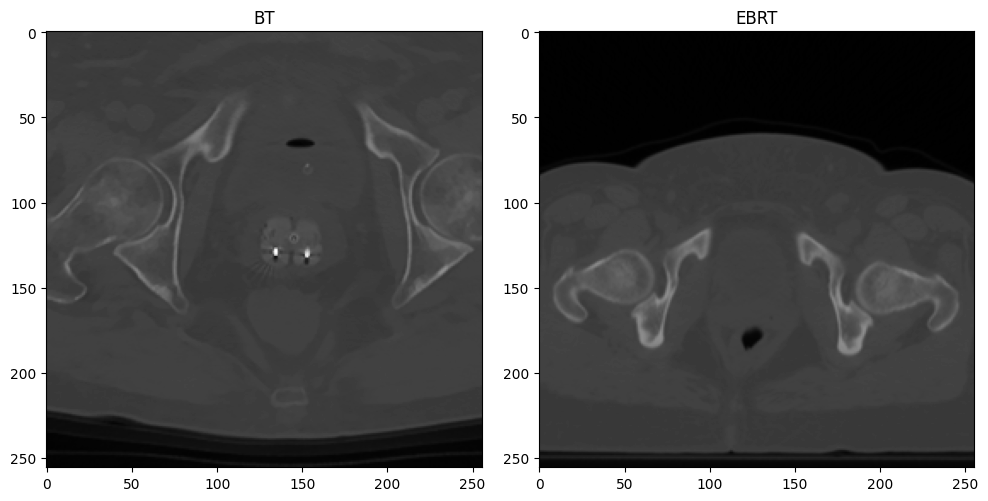

In [8]:
import matplotlib.pyplot as plt

print(bt_array.shape, ebrt_array.shape)

bt_slice = bt_array[85][128:-128, 128:-128]
ebrt_slice = ebrt_array[66][128:-128, 128:-128]

# bt_slice = np.log(1-bt_slice/1024)
# ebrt_slice = np.log(1-ebrt_slice/1024)

min_val = min(bt_slice.min(), ebrt_slice.min())
max_val = max(bt_slice.max(), ebrt_slice.max())

plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.title("BT")
plt.imshow(bt_slice, vmin=min_val, vmax=max_val, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("EBRT")
plt.imshow(ebrt_slice, vmin=min_val, vmax=max_val, cmap='gray')
plt.tight_layout()
plt.show()

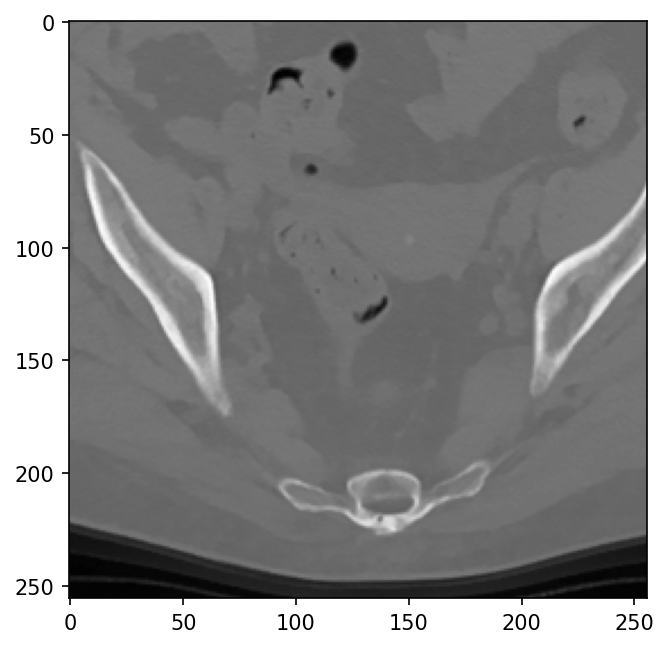

In [9]:
index = 115
plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(bt_array[index][128:-128, 128:-128], cmap='gray')

In [10]:
output_dir_bt = Path("./slices_bt_center256")
output_dir_bt.mkdir(parents=True, exist_ok=True)

In [11]:
data_root = Path("/mnt/d/PRV/GYN_Geneva_wo_Needles")

for idx_case in range(6, 26):
    case_id = Path(f"Case{idx_case}")
    print(f"Data root: {data_root}")
    print(f"Case ID: {case_id}")
    try: paths = load_case_paths(data_root, case_id)
    except: continue

    ## CT
    print(paths['ct'])
    try: bt_image, bt_array, _ = dhelp.load_ct_volume(paths['ct'])
    except:
        print(f"Failed to load CT for {case_id}")
        continue

    for idx_slice in range(bt_array.shape[0]):
        plt.imsave(output_dir_bt / f"{case_id}_{idx_slice:03d}.png", bt_array[idx_slice][128:-128, 128:-128], cmap='gray')

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case7
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case7/CT_0_20240123/series_2_1.3.6.1.4.1.2452.6.119199712.1243047606.2501252749.3382324425
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case8
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case8/CT_0_20240202/series_2_1.3.6.1.4.1.2452.6.3351915917.1076593743.1821453241.828281496
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case9
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case9/CT_0_20240318/series_2_1.3.6.1.4.1.2452.6.943708742.1313552506.3846646192.867230644
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case10
/mnt/d/PRV/GYN_Geneva_wo_Needles/Case10/CT_0_20240823/series_4_1.3.6.1.4.1.2452.6.356448218.1341785047.3605713818.1153220155
Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case11
/mnt/d/PRV/GYN_Geneva_w

In [12]:
output_dir_ebrt = Path("./slices_ebrt_center256")
output_dir_ebrt.mkdir(parents=True, exist_ok=True)

In [13]:
data_root = Path("/mnt/d/PRV/GYN External Beam CT Datasets")


for idx_case in range(1, 11):
    case_id = Path(f"Case{idx_case}")
    print(f"Data root: {data_root}")
    print(f"Case ID: {case_id}")
    try: paths = load_case_paths_ebrt(data_root, case_id)
    except: continue

    ## CT
    path_ct = data_root / case_id
    print(path_ct)
    try: ebrt_image, ebrt_array, _ = dhelp.load_ct_volume(path_ct)
    except:
        print(f"Failed to load CT for {case_id}")
        continue

    for idx_slice in range(ebrt_array.shape[0]):
        plt.imsave(output_dir_ebrt / f"{case_id}_{idx_slice:03d}.png", ebrt_array[idx_slice][128:-128, 128:-128], cmap='gray')

Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case1
/mnt/d/PRV/GYN External Beam CT Datasets/Case1
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case2
/mnt/d/PRV/GYN External Beam CT Datasets/Case2
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case3
/mnt/d/PRV/GYN External Beam CT Datasets/Case3
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case4
/mnt/d/PRV/GYN External Beam CT Datasets/Case4
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case5
/mnt/d/PRV/GYN External Beam CT Datasets/Case5
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case6
/mnt/d/PRV/GYN External Beam CT Datasets/Case6
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case7
/mnt/d/PRV/GYN External Beam CT Datasets/Case7
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case8
/mnt/d/PRV/GYN External Beam CT Datasets/Case8
Data root: /mnt/d/PRV/GYN External Beam CT Datasets
Case ID: Case9
/mnt/d/PRV/GYN Extern